# Import modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from pysheds.grid import Grid
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

%matplotlib inline

# Read raw DEM

In [2]:
grid = Grid.from_raster('../data/roi_10m', data_name='dem')

In [3]:
dirmap = (64, 128, 1, 2, 4, 8, 16, 32)

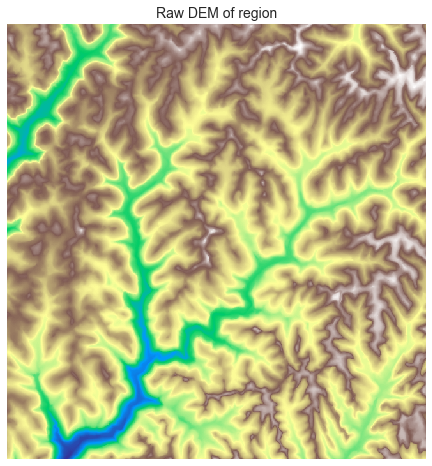

In [4]:
# Plot raw DEM
fig, ax = plt.subplots(figsize=(8,8))
plt.imshow(grid.view('dem'), zorder=1, cmap='terrain')
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.title('Raw DEM of region', size=14)

# Detect and fill pits in DEM

Pits consist of cells at which every surrounding cell is at a higher elevation.

In [5]:
# Detect pits
pits = grid.detect_pits('dem')

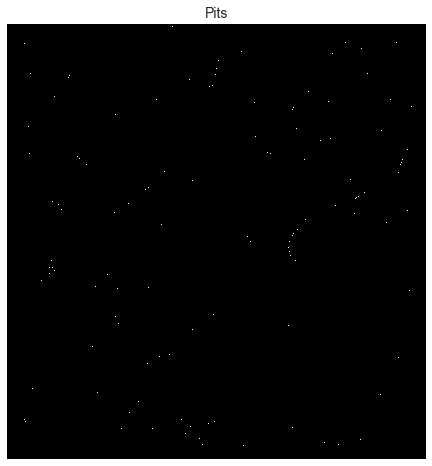

In [6]:
# Plot pits
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(pits, cmap='cubehelix', zorder=1)
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.title('Pits', size=14)

In [7]:
# Fill pits
grid.fill_pits(data='dem', out_name='filled_dem')

# Detect and correct flats in DEM

Flats consist of cells at which every surrounding cell is at the same elevation or higher.

Note that there are some flats that do not drain (flats for which there is no outlet, or "low edge cell").

These flats will need to be dealt with separately.

We will deal with these nondraining flats in the next section.

In [8]:
# Detect flats
flats = grid.detect_flats('filled_dem')

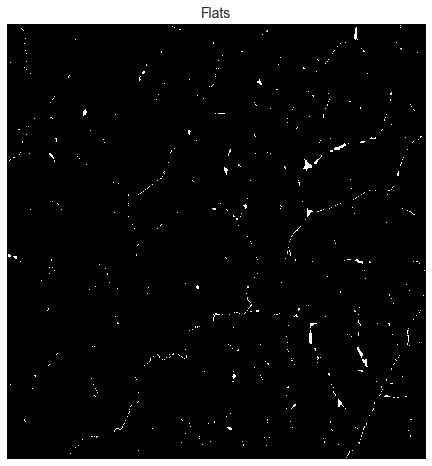

In [9]:
# Plot flats
fig, ax = plt.subplots(figsize=(8,8))
plt.imshow(flats, cmap='cubehelix', zorder=1)
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.title('Flats', size=14)

In [10]:
# Attempt to correct flats
grid.resolve_flats(data='filled_dem', out_name='inflated_dem')

In [11]:
# Detect remaining flats
flats = grid.detect_flats('inflated_dem')

In [12]:
# Compute flow direction based on corrected DEM
grid.flowdir(data='inflated_dem', out_name='dir', dirmap=dirmap)
# Compute flow accumulation based on computed flow direction
grid.accumulation(data='dir', out_name='acc', dirmap=dirmap)

In [13]:
# Delineate catchment at point of highest accumulation
y, x = np.unravel_index(np.argmax(grid.acc), grid.acc.shape)
grid.catchment(x, y, data='dir', out_name='catch',
               dirmap=dirmap, xytype='index')

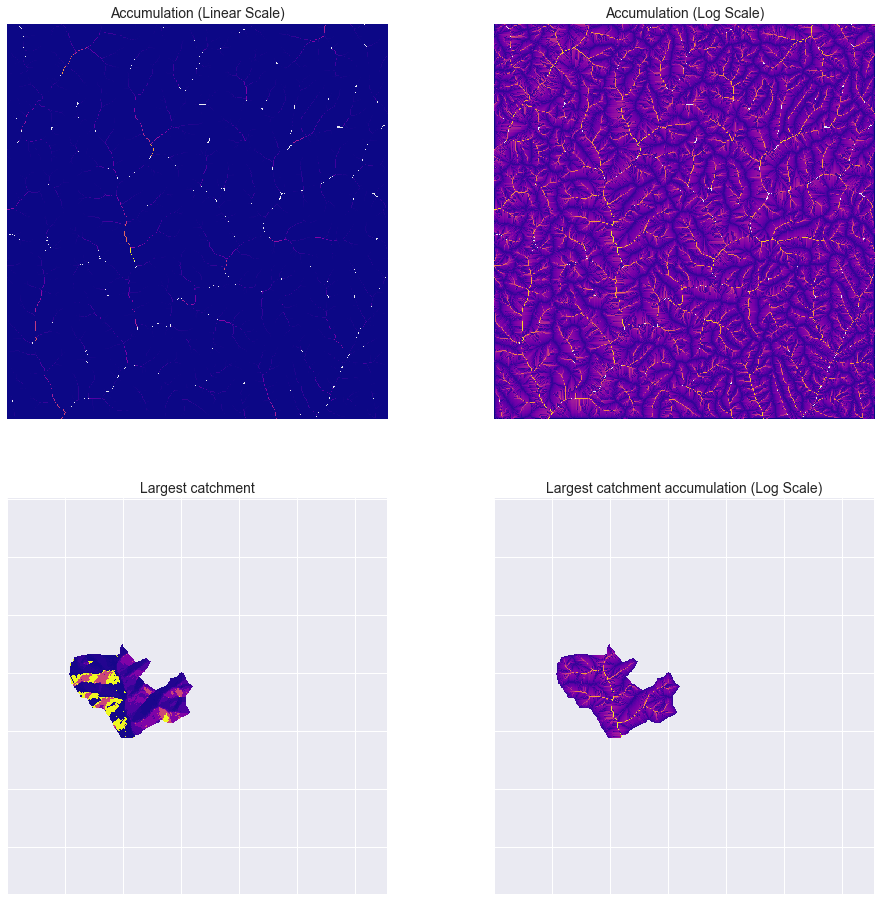

In [14]:
# Plot accumulation and catchment
fig, ax = plt.subplots(2, 2, figsize=(16, 16))
ax[0,0].imshow(np.where(~flats, grid.view('acc') + 1, np.nan), zorder=1, cmap='plasma')
ax[0,1].imshow(np.where(~flats, grid.view('acc') + 1, np.nan), zorder=1, cmap='plasma',
               norm=colors.LogNorm(vmin=1, vmax=grid.acc.max()))
ax[1,0].imshow(np.where(grid.catch, grid.catch, np.nan), zorder=1, cmap='plasma')
ax[1,1].imshow(np.where(grid.catch, grid.view('acc') + 1, np.nan), zorder=1, cmap='plasma',
               norm=colors.LogNorm(vmin=1, vmax=grid.acc.max()))

ax[0,0].set_title('Accumulation (Linear Scale)', size=14)
ax[0,1].set_title('Accumulation (Log Scale)', size=14)
ax[1,0].set_title('Largest catchment', size=14)
ax[1,1].set_title('Largest catchment accumulation (Log Scale)', size=14)

for i in range(ax.size):
    ax.flat[i].set_yticklabels([])
    ax.flat[i].set_xticklabels([])

# Raise nondraining flats, then resolve flats

For flats that have no outlet (low edge cell), we will need to iteratively raise the elevation of the flat to the lowest surrounding elevation until the flat has a low edge cell.

A low edge cell is defined as a cell with the following properties:
- Flow direction is defined
- Has at least one neighboring cell, n, at the same elevation
- The flow direction for this cell n is undefined

In [15]:
# Keep raising nondraining flats until all flats have a "low edge cell"
grid.raise_nondraining_flats(data='filled_dem', out_name='raised_dem')
# In this case, it takes about 280 iterations to remove all nondraining flats
for _ in range(280):
    grid.raise_nondraining_flats(data='raised_dem', out_name='raised_dem')
# After all nondraining flats are drainable, resolve flats    
grid.resolve_flats(data='raised_dem', out_name='inflated_dem')

In [16]:
# Check for remaining flats
flats = grid.detect_flats('inflated_dem')

In [17]:
# There are no remaining flats
flats.any()

False

In [18]:
# Compute flow directions and accumulation
grid.flowdir(data='inflated_dem', out_name='dir', dirmap=dirmap)
grid.accumulation(data='dir', out_name='acc', dirmap=dirmap)
# Find cell with second-highest accumulation
high_acc_cell = np.argsort(grid.acc.ravel())[-2]
# Delineate catchment at second-highest cell
y, x = np.unravel_index(high_acc_cell, grid.acc.shape)
grid.catchment(x, y, data='dir', out_name='catch',
               dirmap=dirmap, xytype='index')

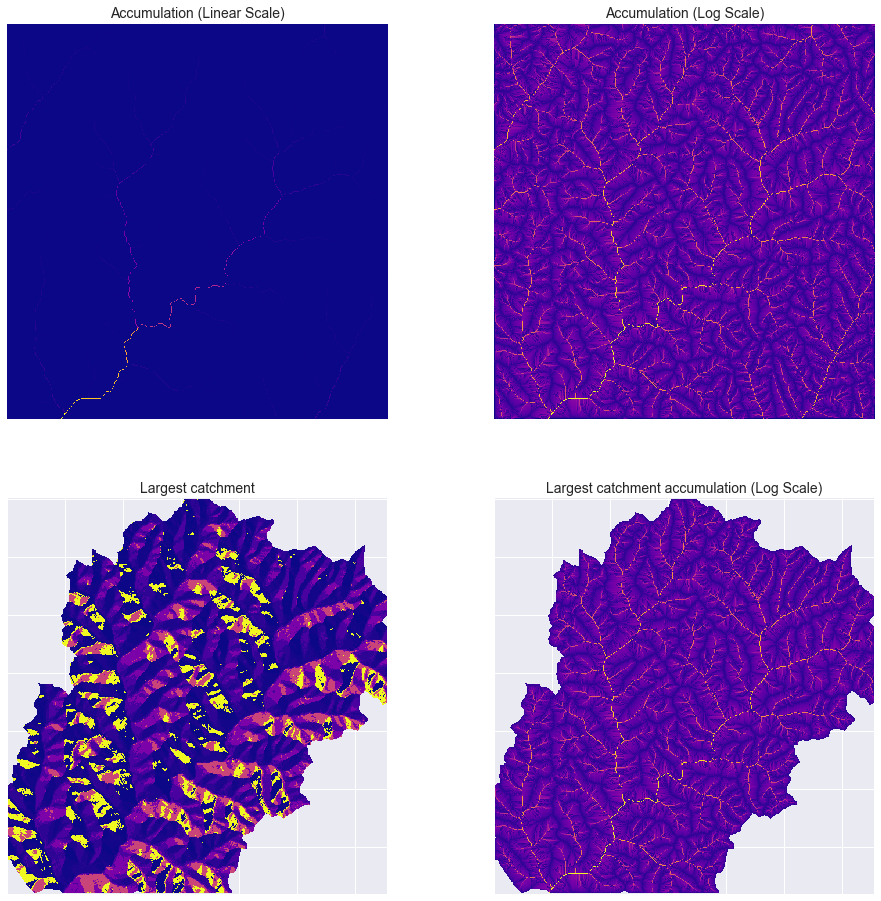

In [19]:
# Plot accumulations and catchment
fig, ax = plt.subplots(2, 2, figsize=(16, 16))
ax[0,0].imshow(np.where(~flats, grid.view('acc') + 1, np.nan), zorder=1, cmap='plasma')
ax[0,1].imshow(np.where(~flats, grid.view('acc') + 1, np.nan), zorder=1, cmap='plasma',
               norm=colors.LogNorm(vmin=1, vmax=grid.acc.max()))
ax[1,0].imshow(np.where(grid.catch, grid.catch, np.nan), zorder=1, cmap='plasma')
ax[1,1].imshow(np.where(grid.catch, grid.view('acc') + 1, np.nan), zorder=1, cmap='plasma',
               norm=colors.LogNorm(vmin=1, vmax=grid.acc.max()))

ax[0,0].set_title('Accumulation (Linear Scale)', size=14)
ax[0,1].set_title('Accumulation (Log Scale)', size=14)
ax[1,0].set_title('Largest catchment', size=14)
ax[1,1].set_title('Largest catchment accumulation (Log Scale)', size=14)

for i in range(ax.size):
    ax.flat[i].set_yticklabels([])
    ax.flat[i].set_xticklabels([])